In [144]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.io import loadmat
# from scipy.fft import fft, ifft

# # Load .mat file
# mat = loadmat("EMG.mat")
# data = mat['n_Point9']['y_values'][0,0]['values'][0,0].squeeze()
# dt = float(mat['n_Point9']['x_values'][0,0]['increment'][0,0])

# N = len(data)
# Fs = 1 / dt
# t = np.arange(1, N + 1) * dt
# fvec = np.arange(0, N) / N * Fs

# data_fft = fft(data)

# plt.figure()
# plt.semilogy(np.abs(data_fft))
# plt.title('FFT Magnitude Spectrum')

# # Zero selected frequencies (adjust indices as needed)
# data_fft[29997:30049] = 0
# data_fft[N//2:] = 0

# data_filtered = np.real(ifft(data_fft))
# data_filtered_fft_ifft = data_filtered

# plt.figure()
# plt.plot(data, label='Original')
# plt.plot(data_filtered, label='Filtered')
# plt.legend()
# plt.title('Original and Filtered Signal')

# plt.figure()
# plt.plot(data_filtered)
# plt.title('Filtered Signal')
# plt.show()

### FFC + CWT

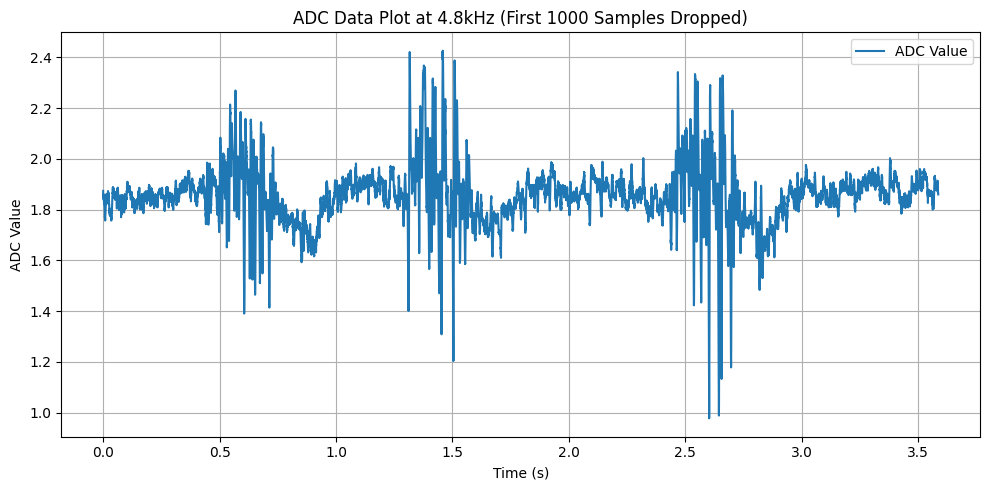

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Parameters
filename = 'adc_log.csv'
sampling_rate = 4800  # in Hz

# Load ADC values (single column)
adc_values = pd.read_csv(filename, header=None).squeeze()  # Convert to Series

# Drop first 1000 samples
adc_values = adc_values[100:].reset_index(drop=True)
time = np.arange(len(adc_values)) / sampling_rate  # Recompute time axis

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time, adc_values, label='ADC Value')
plt.xlabel('Time (s)')
plt.ylabel('ADC Value')
plt.title('ADC Data Plot at 4.8kHz (First 1000 Samples Dropped)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

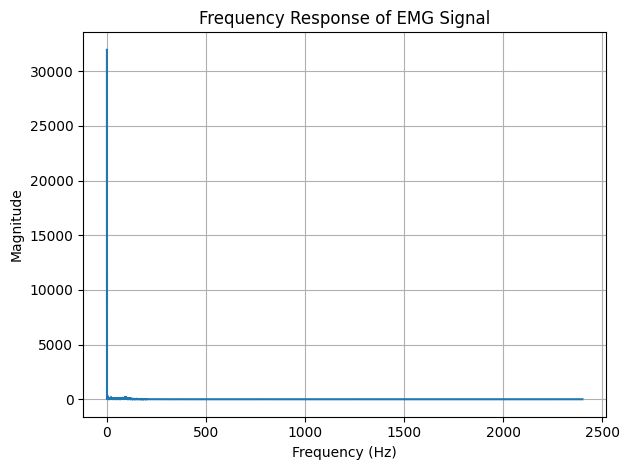

In [146]:
# FFT of the original signal
n = len(adc_values)
fft_signal = np.fft.fft(adc_values)
fft_freq = np.fft.fftfreq(n, d=1/fs)

# Plot the frequency response
fig, ax = plt.subplots()
ax.plot(fft_freq[:n//2], np.abs(fft_signal)[:n//2])
ax.set_title("Frequency Response of EMG Signal")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Magnitude")
ax.grid()

plt.tight_layout()
plt.show()

In [147]:
from scipy.signal import butter, filtfilt, iirnotch, hilbert, lfilter
import numpy as np
from numpy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
import pandas as pd
import pywt

In [148]:
signal = adc_values
t = time
fs = sampling_rate

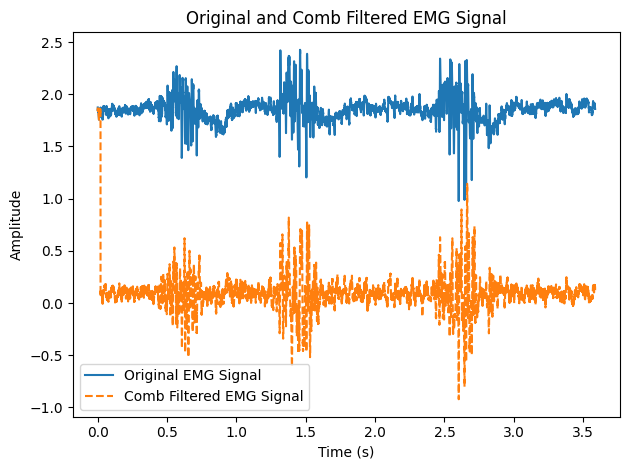

In [149]:
# Define the comb filter
def comb_filter(signal, delay, alpha):
    b = np.zeros(delay + 1)
    b[0] = 1
    b[-1] = -alpha
    a = [1]
    return lfilter(b, a, signal)

# Parameters for the comb filter
delay = int(fs / 50)  # Delay in samples (for 50 Hz)
alpha = 0.95  # Feedback coefficient

# Apply the comb filter to the signal
filtered_signal_FFC = comb_filter(signal, delay, alpha)

# Plot the original and filtered signals
fig, ax = plt.subplots()
ax.plot(t, signal, label='Original EMG Signal')
ax.plot(t, filtered_signal_FFC, label='Comb Filtered EMG Signal', linestyle='--')
ax.set_title("Original and Comb Filtered EMG Signal")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.legend()

plt.tight_layout()
plt.show()

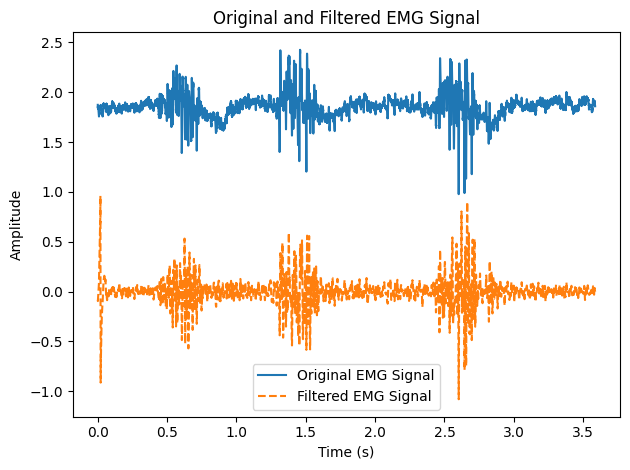

In [150]:
# Design the bandpass filter
lowcut = 20.0
highcut = 500.0
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(4, [low, high], btype='band')

# Apply the filter to the signal
filtered_signal = filtfilt(b, a, filtered_signal_FFC)

# Plot the original and filtered signals
fig, ax = plt.subplots()
ax.plot(t, signal, label='Original EMG Signal')
ax.plot(t, filtered_signal, label='Filtered EMG Signal', linestyle='--')
ax.set_title("Original and Filtered EMG Signal")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.legend()

plt.tight_layout()
plt.show()

signal = filtered_signal

In [151]:
# Wvelet parameters
B = 1.5 # Bandwidth
C = 1.0 # Center frequency
wavelet = 'cmor'+ str(B) + '-' + str(C)
print(f"Wavelet: {wavelet}")

#Scales
wav = pywt.ContinuousWavelet(wavelet) 
width = wav.upper_bound - wav.lower_bound
print("width:",width)

# 2 different cases for scales according to literature
all_frequencies = np.array([6, 500])
# significant_frequencies = np.array([20, 250])

# test = np.array([20, 2000])
# test = test / fs

frequencies = all_frequencies / fs # normalized 

scales = pywt.frequency2scale(wavelet, frequencies)
# scales = pywt.frequency2scale(wavelet, test)
print(scales)

Wavelet: cmor1.5-1.0
width: 16.0
[800.    9.6]


Shape of CWT matrix: (2, 17215)
Shape of frequencies: (2,)
Shape of time: (17215,)


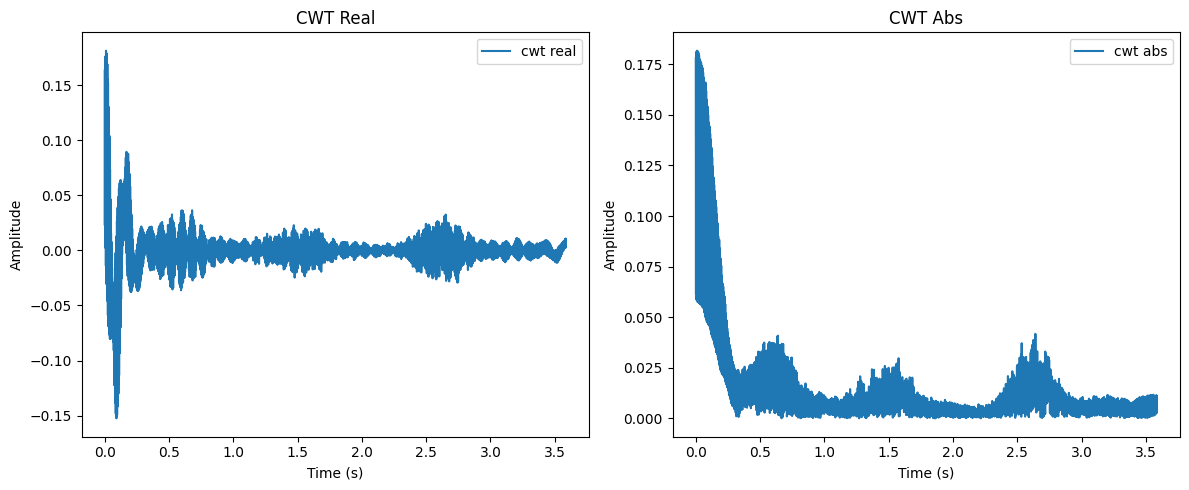

In [152]:
dt = 1/fs
cwtmatr, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=dt)

print(f"Shape of CWT matrix: {cwtmatr.shape}")
print(f"Shape of frequencies: {freqs.shape}")
print(f"Shape of time: {t.shape}")

'''
cwtmatr:
-real: filtered signal for the given scales.
-abs: envelope of the filtered signal for the given scales.
'''

real_cwt = np.real(cwtmatr[0, :])
abs_cwt= np.abs(cwtmatr[0, :])

# real_cwt = real_cwt[1:-1]

# t = t[1:-1]

# Graph of the cwt real and cwt abs side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot cwt real
axs[0].plot(t, np.real(cwtmatr[0, :]), label='cwt real')
axs[0].set_title("CWT Real")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].legend()

# Plot cwt abs
axs[1].plot(t, np.abs(cwtmatr[0, :]), label='cwt abs')
axs[1].set_title("CWT Abs")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Amplitude")
axs[1].legend()


plt.tight_layout()
plt.show()

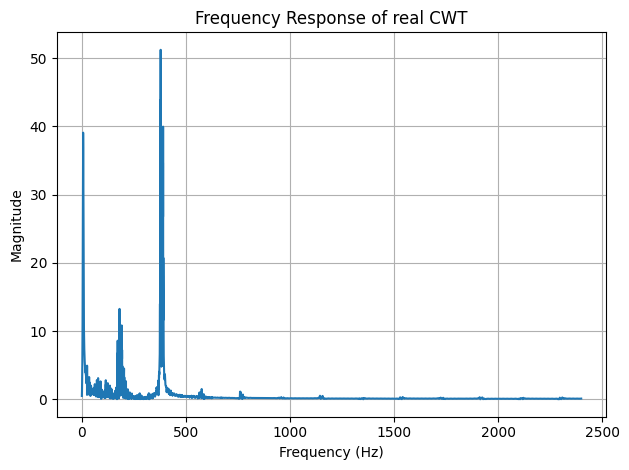

In [153]:
# fft of the real cwt
n = len(np.real(cwtmatr[0,:]))
fft_signal = np.fft.fft(np.real(cwtmatr[0,:]))
fft_freq = np.fft.fftfreq(n, d=1/fs)

# Plot the frequency response
fig, ax = plt.subplots()
ax.plot(fft_freq[:n//2], np.abs(fft_signal)[:n//2])
ax.set_title("Frequency Response of real CWT")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Magnitude")
ax.grid()

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Original and Filtered Signal')

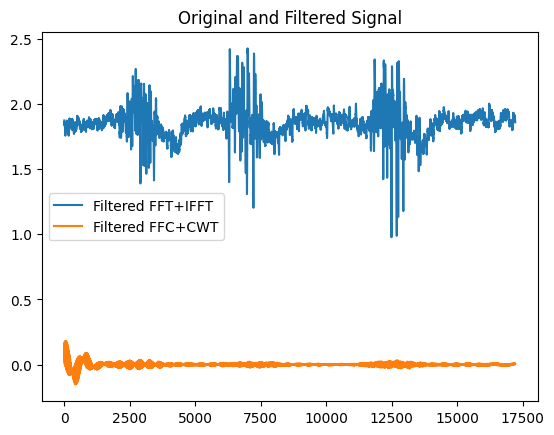

In [154]:
plt.figure()
plt.plot(adc_values, label='Filtered FFT+IFFT')
plt.plot(real_cwt, label='Filtered FFC+CWT')
plt.legend()
plt.title('Original and Filtered Signal')

In [155]:
#Scales
wav = pywt.ContinuousWavelet(wavelet) 
width = wav.upper_bound - wav.lower_bound
print("width:",width)

# 2 different cases for scales according to literature
all_frequencies = np.arange(6, 500)

frequencies = all_frequencies / fs # normalized 

scales = pywt.frequency2scale(wavelet, frequencies)
# print(scales)

width: 16.0


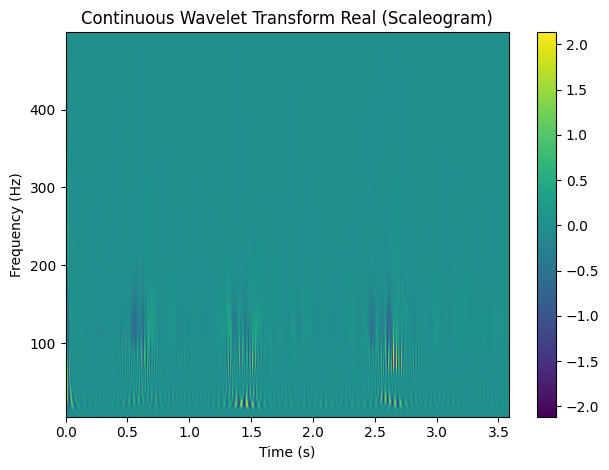

In [156]:
cwtmatr, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=dt)

# Plot result using matplotlib's pcolormesh (image with annotated axes)
fig, ax = plt.subplots()
pcm = ax.pcolormesh(t, freqs, np.real(cwtmatr[:-1,:-1]))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
ax.set_title("Continuous Wavelet Transform Real (Scaleogram)")
# ax.set_xlim([10, 15])
fig.colorbar(pcm, ax=ax)
plt.tight_layout()
plt.show()